<a href="https://colab.research.google.com/github/Azuremis/make_your_first_gan_with_pytorch/blob/master/handwritten_digits_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# mount drive to read data files
from google.colab import drive
drive.mount("./mount")

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [33]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MNIST Dstaset class

In [34]:
class MnistDataset(Dataset):
  
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # mage target (label)
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))  # create target tensor 
        target[label] = 1.0  # using one hot encoding

        # image data (normalise from 0-255 to 0-1)
        image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

        # return label, image data and target tensor
        return label, image_values, target

    def plot_image(self, index):
        # visualise image from pixels
        img_arr = self.data_df.iloc[index, 1:].values.reshape(28, 28) 
        plt.title("Label: " + str(self.data_df.iloc[index, 0]))
        plt.imshow(img_arr, interpolation='none', cmap="Blues")
        plt.show()

In [35]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/make_your_first_gan_with_pytorch/mnist_data/mnist_train.csv')

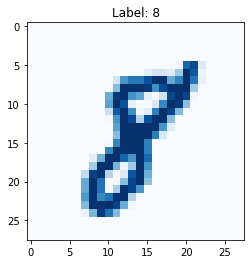

In [36]:
mnist_dataset.plot_image(17)

MNIST discriminator

In [37]:
# set up the discriminator
class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # set up nn layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),  # reduce vanishing gradient issue for large signal values
            nn.LayerNorm(200),  # normalise signals to avoid network saturation from large values
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # set up loss
        self.loss_function = nn.BCELoss()  # BCELoss better for classification tasks

        # set up optimiser
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # set up progress monitors
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # just run the model
        return self.model(inputs)

    def train(self, inputs, targets):
        # calculate predictions
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # track training progress
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())  # accumulate error
        if self.counter % 10000 == 0:
            print("counter = ", self.counter)

        # zero gradients
        self.optimiser.zero_grad()
        # perform backward pass by calcuating gradients
        loss.backward()
        # update learnable parameters
        self.optimiser.step()

    def plot_progress(self):

        df = pd.DataFrame(self.progress, columns=["loss"])    
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


Testing the discriminator

In [38]:
# generates random image
def generate_random_image(size):
    # uniformly distributed data is best for random image
    return torch.rand(size) 

In [39]:
%%time

discrim = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # train with real data
    discrim.train(image_data_tensor, torch.FloatTensor([1.0]))
    # train with fake data
    discrim.train(generate_random_image(784), torch.FloatTensor([0.0]))


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 47s, sys: 3.72 s, total: 4min 51s
Wall time: 4min 51s


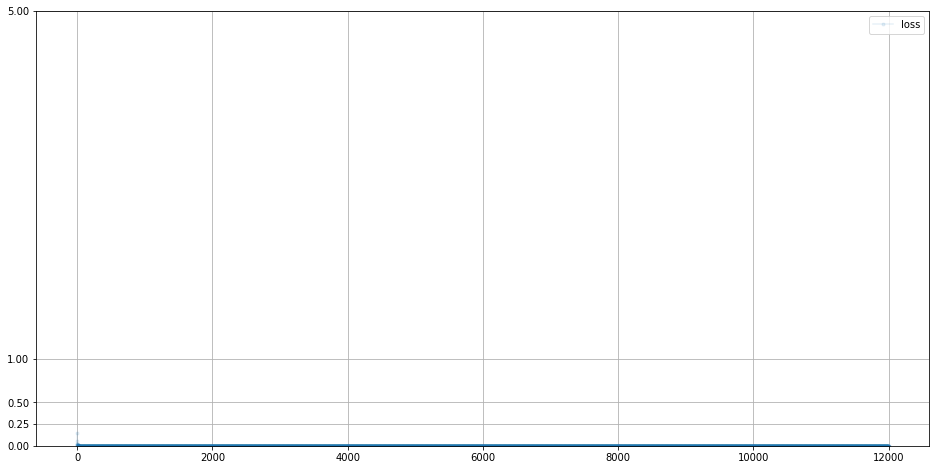

In [40]:
# plot model loss
discrim.plot_progress()

In [41]:
# manual run to check discriminitor is working
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
    print(discrim.forward(image_data_tensor).item())

for i in range(4):
    print(discrim.forward(generate_random_image(784)).item())


1.0
1.0
1.0
1.0
1.0154959338704028e-11
1.2073997184003371e-11
1.0223017744837026e-11
8.931960206182143e-12


MNIST generator

In [42]:
class Generator(nn.Module):
    
    def __init__(self):
        # call parent pytorch class
        super().__init__()

        # set up layers
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),  
            nn.LayerNorm(200),  
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # set up optimiser
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # set up progress tracking
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, discriminator, inputs, targets):
        # calculate network outputs, i.e. generate data
        generator_output = self.forward(inputs)

        # pass generated data to discriminator for classification
        discriminator_output = discriminator.forward(generator_output)

        # calculate loss using discriminator
        loss = discriminator.loss_function(discriminator_output, targets)

        # track generator loss
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        # zero gradients
        self.optimiser.zero_grad()
        # perform backward pass
        loss.backward()
        # update the parameters
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".",
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

Checking generator output

In [43]:
def generate_random_seed(size):
    # normalised dist is best for generator seed values 
    return torch.randn(size)

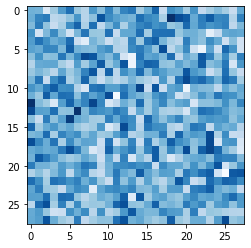

In [44]:
# check that generated data is right type and shape
seed = generate_random_seed(100)
gener = Generator()
output = gener.forward(seed)
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img, interpolation="none", cmap="Blues")

Training the GAN

In [66]:
%%time

# create discriminator and generator
Dis = Discriminator()
Gen = Generator()

# train discriminator and generator

epochs = 4

for i in range(epochs):
        
    for label, image_data_tensor, target_tensor in mnist_dataset:

        # train the discriminator on real data
        Dis.train(image_data_tensor, torch.FloatTensor([1.0]))

        # train the discriminator on false data, use detach() so gradients in Gen are not calculated
        Dis.train(Gen.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

        # train the generator 
        Gen.train(Dis, generate_random_seed(100), torch.FloatTensor([1.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 33min 22s, sys: 26.4 s, total: 33min 48s
Wall time: 33min 52s


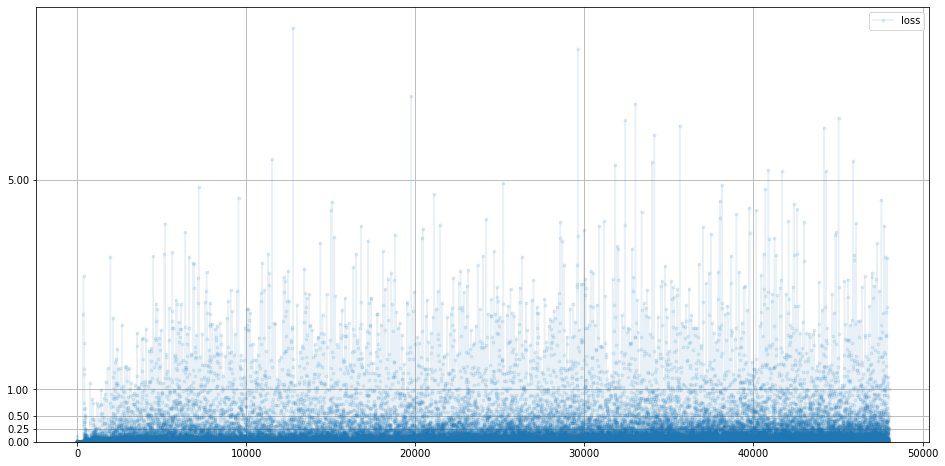

In [67]:
# plot discriminator loss
Dis.plot_progress()

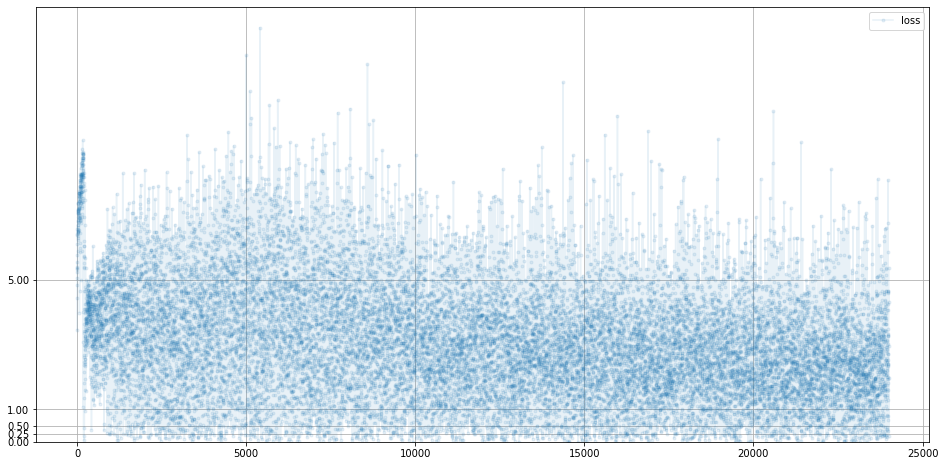

In [68]:
# plot generator loss
Gen.plot_progress()

Examining generated images

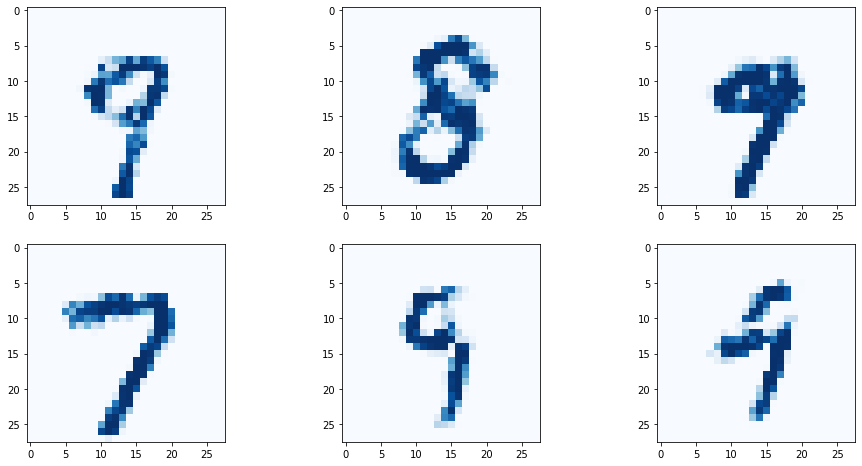

In [85]:
# plot 2 by 3 array of generated images
f, axarr = plt.subplots(2, 3, figsize=(16, 8))
for i in range(2):
    for j in range(3):
        output = Gen.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28, 28)
        axarr[i, j].imshow(img, interpolation="none", cmap="Blues")

Exploring seeds

In [70]:
# Fix seeds
seed_1 = generate_random_seed(100)
seed_2 = generate_random_seed(100)

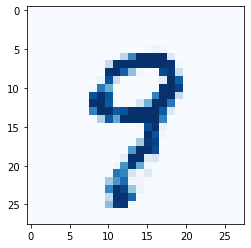

In [71]:
img_1 = Gen.forward(seed_1).detach().numpy().reshape(28, 28)
plt.imshow(img_1, interpolation="none", cmap="Blues")

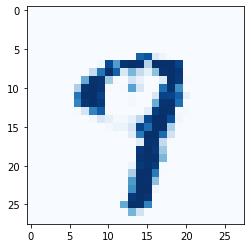

In [72]:
img_2 = Gen.forward(seed_2).detach().numpy().reshape(28, 28)

plt.imshow(img_2, interpolation="none", cmap="Blues")

What images do we get inbetween the seed values?

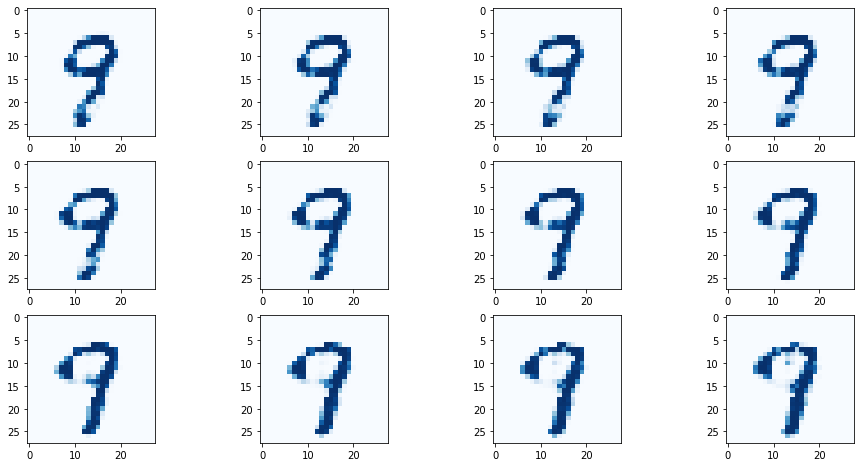

In [76]:
count = 0
f, axarr = plt.subplots(3, 4, figsize=(16, 8))
for i in range(3):
    for j in range(4):
        seed = seed_1 + (seed_2 - seed_1) / 11.0 * count
        img = Gen.forward(seed).detach().numpy().reshape(28, 28)
        axarr[i, j].imshow(img, interpolation="none", cmap="Blues")
        count += 1

What image do we get if we add the seed values?

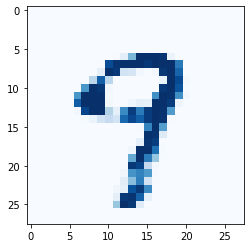

In [77]:
seed_3 = seed_1 + seed_2
img_3 = Gen.forward(seed_3).detach().numpy().reshape(28, 28)
plt.imshow(img_3, interpolation="none", cmap="Blues")

What image do we get if we subtract the seed values?

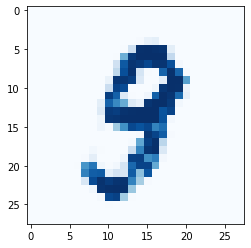

In [78]:
seed_4 = seed_1 - seed_2
img_4 = Gen.forward(seed_4).detach().numpy().reshape(28, 28)
plt.imshow(img_4, interpolation="none", cmap="Blues")